In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as stats 

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression


SOURCES : 

PAUV: https://www.insee.fr/fr/statistiques/4507225?sommaire=4507229&q=principaux+indicateurs+sur+les+revenus+et+la+pauvret%C3%A9%20aux+niveaux+national+et+local

CRIM: https://www.data.gouv.fr/datasets/bases-statistiques-communale-departementale-et-regionale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/

CHOM:https://www.insee.fr/fr/statistiques/series/102760732

URB: https://www.insee.fr/fr/statistiques/5039853?sommaire=5040030&utm_

DENSITE: https://www.insee.fr/fr/statistiques/5544529?sommaire=5435421&utm

EDU: https://www.insee.fr/fr/statistiques/4507225?sommaire=4507229&q=principaux+indicateurs+sur+les+revenus+et+la+pauvret%C3%A9%20aux+niveaux+national+et+local

###PAUV

In [3]:
pauv=pd.read_csv('cc_filosofi_2017_DEP.CSV',sep=';')
pauv.head()

,CODGEO,NBMENFISC17,NBPERSMENFISC17,MED17,PIMP17,TP6017,TP60AGE117,TP60AGE217,TP60AGE317,TP60AGE417,...,PPEN17,PPAT17,PPSOC17,PPFAM17,PPMINI17,PPLOGT17,PIMPOT17,D117,D917,RD17
0,01,256670,619078,22640,54.1,10.5,14.9,12.0,11.9,10.5,...,25.2,8.7,4.0,2.0,1.1,0.9,-16.0,12460,42680,3.4
1,02,222104,518441,19100,44.3,18.5,29.7,22.7,21.8,18.9,...,30.7,8.2,7.6,2.9,2.9,1.8,-14.2,10440,32130,3.1
2,03,158099,329200,19750,44.3,15.4,25.3,19.4,18.8,16.1,...,37.6,10.3,6.4,2.0,2.8,1.6,-14.6,11070,32880,3.0
3,04,73922,157059,19940,46.4,16.6,24.6,20.8,20.7,16.9,...,36.3,12.1,5.5,1.9,2.2,1.4,-15.1,10730,34680,3.2
4,05,63739,135275,20350,48.2,13.9,20.1,16.6,16.8,14.9,...,35.2,11.0,5.0,1.9,1.8,1.3,-15.0,11430,34340,3.0


In [4]:
# garder les colonnes utiles
pauv=pauv[['CODGEO','TP6017','MED17','RD17']]

#renommer pour plus de clarté
pauv=pauv.rename(columns={
    'CODGEO':'departement',
    'TP6017':'tx_pauvrete',
    'MED17':'revenu_median',
    'RD17':'revenu_moyen'
})

#remplacer les départements 2A et 2B par 20
pauv['departement']=pauv['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la moyenne pour les colonnes de taux & revenus
pauv = pauv.groupby("departement", as_index=False)[["tx_pauvrete", "revenu_median", "revenu_moyen"]].mean()

#filtrer et ne garder que les départements de France Métropolitaine
pauv=pauv[pauv['departement'].astype(int)<=95]

print(pauv.head())
print('***************************************************************')
print(pauv.describe())




  departement  tx_pauvrete  revenu_median  revenu_moyen
0          20        18.55        20060.0           3.6
1          01        10.50        22640.0           3.4
2          02        18.50        19100.0           3.1
3          03        15.40        19750.0           3.0
4          04        16.60        19940.0           3.2
***************************************************************
       tx_pauvrete  revenu_median  revenu_moyen
count    95.000000       95.00000     95.000000
mean     14.380526    20788.00000      3.174737
std       2.997670     1619.34489      0.486404
min       9.100000    17310.00000      2.600000
25%      12.350000    19865.00000      2.900000
50%      14.300000    20410.00000      3.100000
75%      15.450000    21320.00000      3.300000
max      27.900000    27400.00000      6.300000


In [5]:
print('***********************************************')
print('nombre de valeurs null')
print(pauv.isnull().sum().sum())
if pauv.isnull().sum().sum()!=0:
    print('nombre de valeur null par colonne')
    print(pauv.isnull().sum())

***********************************************
nombre de valeurs null
0


###CRIM

In [6]:
crim_raw=pd.read_csv('donnee-dep-data.gouv-2024-geographie2025-produit-le2025-06-04.csv',sep=';')
crim_raw.head()

,Code_departement,Code_region,annee,indicateur,unite_de_compte,nombre,taux_pour_mille,insee_pop,insee_pop_millesime,insee_log,insee_log_millesime
0,01,84,2016,Homicides,Victime,5,"0,0078318",638425,2016,308491,2016
1,02,32,2016,Homicides,Victime,10,"0,0186520",536136,2016,264180,2016
2,03,84,2016,Homicides,Victime,4,"0,0117861",339384,2016,206980,2016
3,04,93,2016,Homicides,Victime,2,"0,0123028",162565,2016,126760,2016
4,05,93,2016,Homicides,Victime,0,"0,0000000",141107,2016,134647,2016


In [7]:
#filtrer en gardant l'année 2017
crim_2017 = crim_raw[crim_raw["annee"]==2017]


# Somme des crimes pour chaque département
crim = crim_2017.groupby("Code_departement")["nombre"].sum().reset_index()

# Garde la population 
pop_dep = crim_2017.groupby("Code_departement")["insee_pop"].first().reset_index()

# Fusionner
crim = crim.merge(pop_dep, on="Code_departement")

print(crim.describe())
print(crim.head())



              nombre     insee_pop
count     101.000000  1.010000e+02
mean    32149.831683  6.611966e+05
std     39230.861918  5.074315e+05
min      1879.000000  7.660100e+04
25%      9599.000000  2.833720e+05
50%     20033.000000  5.338190e+05
75%     34413.000000  8.245030e+05
max    278863.000000  2.604361e+06
  Code_departement  nombre  insee_pop
0               01   21062     643350
1               02   20059     534490
2               03   12125     337988
3               04    7314     163915
4               05    6557     141284


In [8]:
# garder les colonnes utiles
crim=crim[['Code_departement','nombre','insee_pop']]

#renommer pour plus de clarté
crim=crim.rename(columns={
    'Code_departement':'departement',
    'nombre':'nombre_crimes',
    'insee_pop':'population'
})

#remplacer les départements 2A et 2B par 20
crim['departement']=crim['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la somme de la population
crim = crim.groupby("departement", as_index=False)[["nombre_crimes",  "population"]].sum()

#filtrer et ne garder que les départements de France Métropolitaine
crim=crim[crim['departement'].astype(int)<=95]

print(crim.head())
print('***************************************************************')
print(crim.describe())
print('nompre de lignes & de colonnes')
print(crim.shape)
print('***********************************************')


  departement  nombre_crimes  population
0          20          11978      334938
1          01          21062      643350
2          02          20059      534490
3          03          12125      337988
4          04           7314      163915
***************************************************************
       nombre_crimes    population
count      95.000000  9.500000e+01
mean    33227.810526  6.804119e+05
std     40157.990924  5.138584e+05
min      1879.000000  7.660100e+04
25%     10970.500000  3.087325e+05
50%     20059.000000  5.390670e+05
75%     36324.500000  8.667655e+05
max    278863.000000  2.604361e+06
nompre de lignes & de colonnes
(95, 3)
***********************************************


In [9]:
crim["tx_crim_pour_100 M_hab"] = (crim["nombre_crimes"] / crim["population"]) * 100000 #taux de criminalité pour 100 000 habitants
print(crim.head())
crim.describe()

  departement  nombre_crimes  population  tx_crim_pour_100 M_hab
0          20          11978      334938             3576.184249
1          01          21062      643350             3273.801197
2          02          20059      534490             3752.923347
3          03          12125      337988             3587.405470
4          04           7314      163915             4462.068755


,nombre_crimes,population,tx_crim_pour_100 M_hab
count,95.000000,9.500000e+01,95.000000
mean,33227.810526,6.804119e+05,4132.519919
std,40157.990924,5.138584e+05,1385.850369
min,1879.000000,7.660100e+04,2325.981963
25%,10970.500000,3.087325e+05,3340.740509
50%,20059.000000,5.390670e+05,3743.793246
75%,36324.500000,8.667655e+05,4573.800218
max,278863.000000,2.604361e+06,12747.871340


In [10]:
# garder les colonnes utiles
crim=crim[['departement','tx_crim_pour_100 M_hab']]
print(crim.head())

  departement  tx_crim_pour_100 M_hab
0          20             3576.184249
1          01             3273.801197
2          02             3752.923347
3          03             3587.405470
4          04             4462.068755


FUSION FICHIERS

In [11]:

# Fusion population + pauvreté
df = pauv.merge(crim, on="departement", how="inner")

print(df)


   departement  tx_pauvrete  revenu_median  revenu_moyen  \
0           20        18.55        20060.0           3.6   
1           01        10.50        22640.0           3.4   
2           02        18.50        19100.0           3.1   
3           03        15.40        19750.0           3.0   
4           04        16.60        19940.0           3.2   
..         ...          ...            ...           ...   
90          91        12.70        23360.0           3.5   
91          92        11.80        27090.0           4.9   
92          93        27.90        17310.0           3.8   
93          94        16.30        22290.0           4.1   
94          95        16.60        21470.0           3.6   

    tx_crim_pour_100 M_hab  
0              3576.184249  
1              3273.801197  
2              3752.923347  
3              3587.405470  
4              4462.068755  
..                     ...  
90             4781.387669  
91             5144.764265  
92             806

VISUALISATION

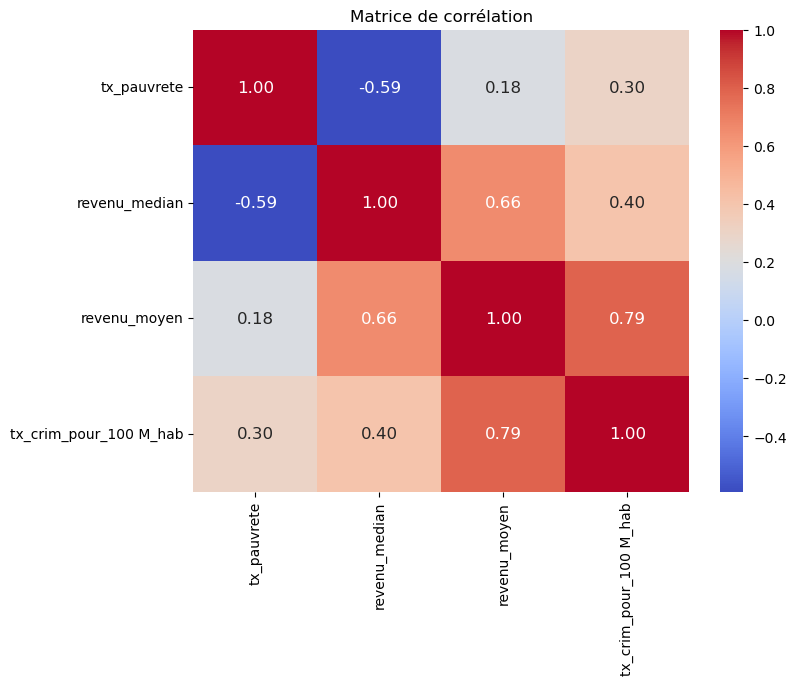

In [ ]:
# Calcul de la matrice de corrélation
corr_matrix = df[["tx_pauvrete", "revenu_median", "revenu_moyen", "tx_crim_pour_100 M_hab"]].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",annot_kws={"size": 10})
plt.title("Matrice de corrélation")
plt.show()


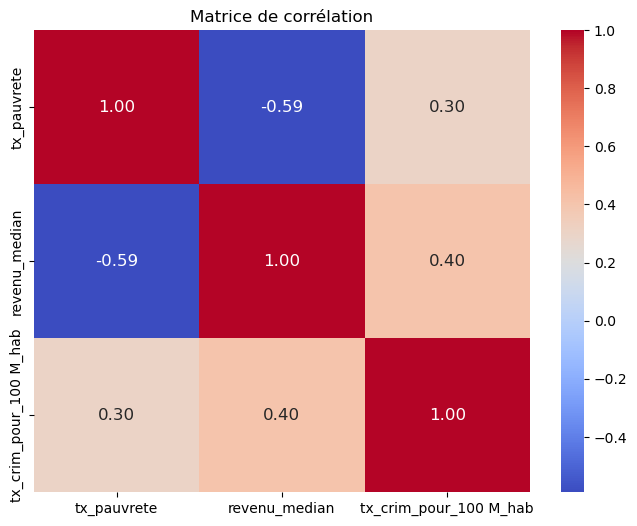

In [52]:
# Calcul de la matrice de corrélation (sans revenu_moyen)
corr_matrix = df[["tx_pauvrete", "revenu_median", "tx_crim_pour_100 M_hab"]].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",annot_kws={"size": 12})
plt.title("Matrice de corrélation")
plt.show()

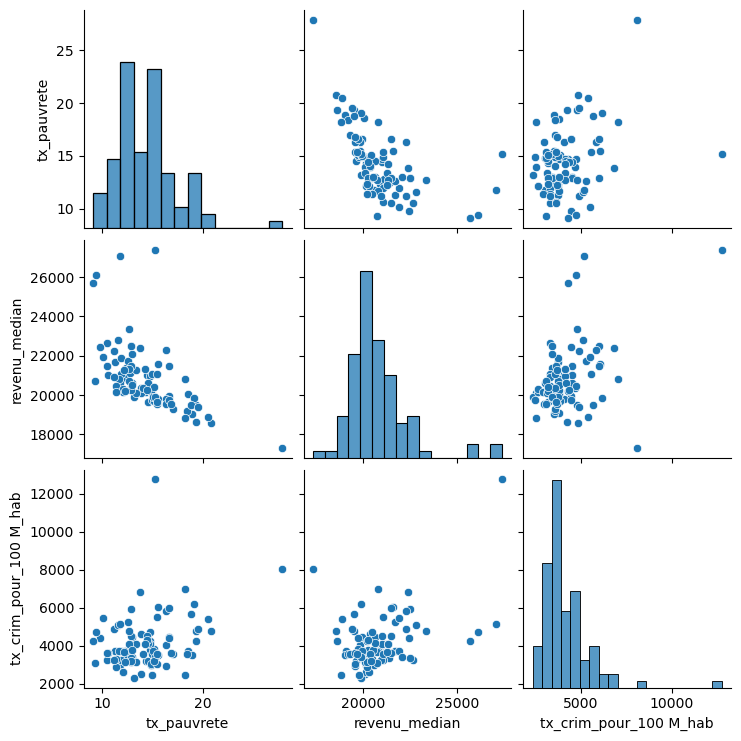

In [14]:
sns.pairplot(df[["tx_pauvrete", "revenu_median", "tx_crim_pour_100 M_hab"]])
plt.show()


###CHOM

In [15]:

chom=pd.read_excel('TAUX-CHOMAGE_dep_2017.xlsx')
chom.head()

,Libellé,idBank,2017-T1,2017-T2,2017-T3,2017-T4
0,Taux de chômage localisé par département - Ave...,1515862,7.1,7.0,7.0,6.6
1,Taux de chômage localisé par département - Ain,1515866,7.0,6.9,6.8,6.3
2,Taux de chômage localisé par département - Aisne,1515867,13.2,13.1,13.1,12.4
3,Taux de chômage localisé par département - Allier,1515868,9.8,9.8,9.8,9.3
4,Taux de chômage localisé par département - Alp...,1515869,10.7,10.8,10.9,10.4


In [16]:
print('***********************************************')
print('nombre de valeurs null')
print(chom.isnull().sum().sum())
if chom.isnull().sum().sum()!=0:
    print('nombre de valeur null par colonne')
    print(chom.isnull().sum())

***********************************************
nombre de valeurs null
0


In [17]:
#regrouper le taux de chomage trimestrielle sur l'année 2017 via une moyenne
chom['taux_chomage_2017']=(chom['2017-T1']+chom['2017-T2']+chom['2017-T3']+chom['2017-T4'])/4
print(chom.head())

                                             Libellé   idBank  2017-T1  \
0  Taux de chômage localisé par département - Ave...  1515862      7.1   
1     Taux de chômage localisé par département - Ain  1515866      7.0   
2   Taux de chômage localisé par département - Aisne  1515867     13.2   
3  Taux de chômage localisé par département - Allier  1515868      9.8   
4  Taux de chômage localisé par département - Alp...  1515869     10.7   

   2017-T2  2017-T3  2017-T4  taux_chomage_2017  
0      7.0      7.0      6.6              6.925  
1      6.9      6.8      6.3              6.750  
2     13.1     13.1     12.4             12.950  
3      9.8      9.8      9.3              9.675  
4     10.8     10.9     10.4             10.700  


In [18]:
# Extraire seulement le département depuis "libellé"
chom["departement_nom"] = chom["Libellé"].str.split(" - ").str[-1]


print(chom.head())


                                             Libellé   idBank  2017-T1  \
0  Taux de chômage localisé par département - Ave...  1515862      7.1   
1     Taux de chômage localisé par département - Ain  1515866      7.0   
2   Taux de chômage localisé par département - Aisne  1515867     13.2   
3  Taux de chômage localisé par département - Allier  1515868      9.8   
4  Taux de chômage localisé par département - Alp...  1515869     10.7   

   2017-T2  2017-T3  2017-T4  taux_chomage_2017          departement_nom  
0      7.0      7.0      6.6              6.925                  Aveyron  
1      6.9      6.8      6.3              6.750                      Ain  
2     13.1     13.1     12.4             12.950                    Aisne  
3      9.8      9.8      9.3              9.675                   Allier  
4     10.8     10.9     10.4             10.700  Alpes-de-Haute-Provence  


In [19]:
# garder les colonnes utiles
chom=chom[['taux_chomage_2017','departement_nom']]

#renommer pour plus de clarté
chom=chom.rename(columns={
    'departement_nom':'nom_departement',
    'taux_chomage_2017':'tx_chomage'
})


print(chom.head())



   tx_chomage          nom_departement
0       6.925                  Aveyron
1       6.750                      Ain
2      12.950                    Aisne
3       9.675                   Allier
4      10.700  Alpes-de-Haute-Provence


In [20]:
#associer le nom departement à son code departement
dep=pd.read_csv('departements.csv')
dep.head()

,code_departement,nom_departement
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence
4,05,Hautes-Alpes


In [21]:
# Fusion chomage + departements
df_chom = chom.merge(dep, on="nom_departement", how="inner")
df_chom.head()

,tx_chomage,nom_departement,code_departement
0,6.925,Aveyron,12
1,6.750,Ain,01
2,12.950,Aisne,02
3,9.675,Allier,03
4,10.700,Alpes-de-Haute-Provence,04


In [22]:
# garder les colonnes utiles
df_chom=df_chom[['tx_chomage','code_departement']]

#renommer pour plus de clarté
df_chom=df_chom.rename(columns={
    'code_departement':'departement',
})

#remplacer les départements 2A et 2B par 20
df_chom['departement']=df_chom['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la somme de la population
df_chom = df_chom.groupby("departement", as_index=False)[['tx_chomage']].mean()

#filtrer et ne garder que les départements de France Métropolitaine
df_chom=df_chom[df_chom['departement'].astype(int)<=95]

print(df_chom.head())
print('***************************************************')
print(df_chom.describe())

  departement  tx_chomage
0          20       9.425
1          01       6.750
2          02      12.950
3          03       9.675
4          04      10.700
***************************************************
       tx_chomage
count   95.000000
mean     9.042632
std      1.704448
min      5.650000
25%      7.812500
50%      8.825000
75%      9.762500
max     14.325000


In [23]:
# Fusion df + df_chom
df = df.merge(df_chom, on="departement", how="inner")
df.head()

,departement,tx_pauvrete,revenu_median,revenu_moyen,tx_crim_pour_100 M_hab,tx_chomage
0,20,18.55,20060.0,3.6,3576.184249,9.425
1,01,10.50,22640.0,3.4,3273.801197,6.750
2,02,18.50,19100.0,3.1,3752.923347,12.950
3,03,15.40,19750.0,3.0,3587.405470,9.675
4,04,16.60,19940.0,3.2,4462.068755,10.700


###URB

In [24]:
urb=pd.read_excel('pop_fr_unite_urb_par_dep_2017.xlsx')
urb.head()

,departement,nom_departement,taux_urbanisation
0,01,Ain,67.0
1,02,Aisne,53.2
2,03,Allier,58.3
3,04,Alpes-de-Haute-Provence,61.9
4,05,Hautes-Alpes,59.5


In [25]:
print('***********************************************')
print('nombre de valeurs null')
print(urb.isnull().sum().sum())
if urb.isnull().sum().sum()!=0:
    print('nombre de valeur null par colonne')
    print(urb.isnull().sum())

***********************************************
nombre de valeurs null
0


In [26]:
# garder les colonnes utiles
urb=urb[['departement','taux_urbanisation']]


#renommer pour plus de clarté
urb=urb.rename(columns={
    'taux_urbanisation':'tx_urbanisation'
})

#remplacer les départements 2A et 2B par 20
urb['departement']=urb['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la moyenne du taux d'urbanisation
urb = urb.groupby("departement", as_index=False)[['tx_urbanisation']].median()

#filtrer et ne garder que les départements de France Métropolitaine
urb=urb[urb['departement'].astype(int)<=95]

#remplacer valeur manquante dans 'taux_urbanisation_2017' par la mediane
urb['tx_urbanisation']=urb['tx_urbanisation'].fillna(urb['tx_urbanisation'].median())

print(urb.head())
print('***************************************************')
print(urb.describe())

  departement  tx_urbanisation
0          20            71.85
1          01            67.00
2          02            53.20
3          03            58.30
4          04            61.90
***************************************************
       tx_urbanisation
count        95.000000
mean         68.030000
std          17.712418
min          21.400000
25%          55.750000
50%          66.500000
75%          81.300000
max         100.000000


In [27]:
# Fusion df + urb
df = df.merge(urb, on="departement", how="inner")
df.head()

,departement,tx_pauvrete,revenu_median,revenu_moyen,tx_crim_pour_100 M_hab,tx_chomage,tx_urbanisation
0,20,18.55,20060.0,3.6,3576.184249,9.425,71.85
1,01,10.50,22640.0,3.4,3273.801197,6.750,67.00
2,02,18.50,19100.0,3.1,3752.923347,12.950,53.20
3,03,15.40,19750.0,3.0,3587.405470,9.675,58.30
4,04,16.60,19940.0,3.2,4462.068755,10.700,61.90


###DENS

In [28]:
dens=pd.read_excel('densite_pop_fr_2018.xlsx')
print(dens.head())

   DEP              Département  Densité
0  973                   Guyane        3
1   48                   Lozère       15
2   23                   Creuse       21
3   04  Alpes-de-Haute-Provence       24
4   15                   Cantal       25


In [29]:
print('***********************************************')
print('nombre de valeurs null')
print(dens.isnull().sum().sum())
if dens.isnull().sum().sum()!=0:
    print('nombre de valeur null par colonne')
    print(dens.isnull().sum())

***********************************************
nombre de valeurs null
0


In [30]:
dens.tail()

,DEP,Département,Densité
96,95,Val-d'Oise,994
97,94,Val-de-Marne,5702
98,93,Seine-Saint-Denis,6918
99,92,Hauts-de-Seine,9200
100,75,Paris,20720


In [31]:
# garder les colonnes utiles
dens=dens[['DEP','Densité']]

#renommer pour plus de clarté
dens=dens.rename(columns={
    'DEP':'departement',
    'Densité':'densite_2018_(hab/km²)'
})


#remplacer les départements 2A et 2B par 20
dens['departement']=dens['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la moyenne de la densité
dens = dens.groupby('departement', as_index=False)[['densite_2018_(hab/km²)']].mean()

#filtrer et ne garder que les départements de France Métropolitaine
dens=dens[dens['departement'].astype(int)<=95]



print(dens.head())
print('***************************************************')
print(dens.describe())
print(dens.head())

  departement  densite_2018_(hab/km²)
0          20                    39.0
4          01                   112.0
5          02                    72.0
6          03                    46.0
7          04                    24.0
***************************************************
       densite_2018_(hab/km²)
count               95.000000
mean               572.063158
std               2455.830699
min                 15.000000
25%                 51.500000
50%                 84.000000
75%                164.500000
max              20720.000000
  departement  densite_2018_(hab/km²)
0          20                    39.0
4          01                   112.0
5          02                    72.0
6          03                    46.0
7          04                    24.0


In [32]:
#fusion df + dens
df=df.merge(dens,on='departement',how='inner')
df.head()

,departement,tx_pauvrete,revenu_median,revenu_moyen,tx_crim_pour_100 M_hab,tx_chomage,tx_urbanisation,densite_2018_(hab/km²)
0,20,18.55,20060.0,3.6,3576.184249,9.425,71.85,39.0
1,01,10.50,22640.0,3.4,3273.801197,6.750,67.00,112.0
2,02,18.50,19100.0,3.1,3752.923347,12.950,53.20,72.0
3,03,15.40,19750.0,3.0,3587.405470,9.675,58.30,46.0
4,04,16.60,19940.0,3.2,4462.068755,10.700,61.90,24.0


###SCOL

In [33]:
scol=pd.read_excel('Tauxscol.xlsx')
scol.head()

,Departement,Tx_scol_moy_pop
0,89,57.096456
1,52,57.163559
2,09,57.595605
3,02,57.655850
4,2A,57.689898


In [34]:
print('***********************************************')
print('nombre de valeurs null')
print(scol.isnull().sum().sum())
if scol.isnull().sum().sum()!=0:
    print('nombre de valeur null par colonne')
    print(scol.isnull().sum())

***********************************************
nombre de valeurs null
0


In [35]:
# garder les colonnes utiles
scol=scol[['Departement','Tx_scol_moy_pop']]

#renommer pour plus de clarté
scol=scol.rename(columns={
    'Departement':'departement',
    'Tx_scol_moy_pop':'tx_scolarisation_pop'
})


#remplacer les départements 2A et 2B par 20
scol['departement']=scol['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la moyenne du taux de scolarisation de la population
scol = scol.groupby('departement', as_index=False)[['tx_scolarisation_pop']].mean()

#filtrer et ne garder que les départements de France Métropolitaine
scol=scol[scol['departement'].astype(int)<=95]



print(scol.head())
print('***************************************************')
print(scol.describe())
print('***************************************************')
print(scol.head())

  departement  tx_scolarisation_pop
0          20             58.633464
1          01             58.320593
2          02             57.655850
3          03             58.484813
4          04             58.337452
***************************************************
       tx_scolarisation_pop
count             95.000000
mean              59.911228
std                1.786741
min               57.096456
25%               58.394544
50%               59.565415
75%               61.337253
max               65.120572
***************************************************
  departement  tx_scolarisation_pop
0          20             58.633464
1          01             58.320593
2          02             57.655850
3          03             58.484813
4          04             58.337452


In [36]:
#fusion df + scol
df=df.merge(scol,on='departement',how='inner')
df.head()

,departement,tx_pauvrete,revenu_median,revenu_moyen,tx_crim_pour_100 M_hab,tx_chomage,tx_urbanisation,densite_2018_(hab/km²),tx_scolarisation_pop
0,20,18.55,20060.0,3.6,3576.184249,9.425,71.85,39.0,58.633464
1,01,10.50,22640.0,3.4,3273.801197,6.750,67.00,112.0,58.320593
2,02,18.50,19100.0,3.1,3752.923347,12.950,53.20,72.0,57.655850
3,03,15.40,19750.0,3.0,3587.405470,9.675,58.30,46.0,58.484813
4,04,16.60,19940.0,3.2,4462.068755,10.700,61.90,24.0,58.337452


###EDU

In [37]:
edu=pd.read_csv('cc_filosofi_2017_DEP.CSV',sep=';')
edu.head()

,CODGEO,NBMENFISC17,NBPERSMENFISC17,MED17,PIMP17,TP6017,TP60AGE117,TP60AGE217,TP60AGE317,TP60AGE417,...,PPEN17,PPAT17,PPSOC17,PPFAM17,PPMINI17,PPLOGT17,PIMPOT17,D117,D917,RD17
0,01,256670,619078,22640,54.1,10.5,14.9,12.0,11.9,10.5,...,25.2,8.7,4.0,2.0,1.1,0.9,-16.0,12460,42680,3.4
1,02,222104,518441,19100,44.3,18.5,29.7,22.7,21.8,18.9,...,30.7,8.2,7.6,2.9,2.9,1.8,-14.2,10440,32130,3.1
2,03,158099,329200,19750,44.3,15.4,25.3,19.4,18.8,16.1,...,37.6,10.3,6.4,2.0,2.8,1.6,-14.6,11070,32880,3.0
3,04,73922,157059,19940,46.4,16.6,24.6,20.8,20.7,16.9,...,36.3,12.1,5.5,1.9,2.2,1.4,-15.1,10730,34680,3.2
4,05,63739,135275,20350,48.2,13.9,20.1,16.6,16.8,14.9,...,35.2,11.0,5.0,1.9,1.8,1.3,-15.0,11430,34340,3.0


In [38]:
print(edu.columns)

Index(['CODGEO', 'NBMENFISC17', 'NBPERSMENFISC17', 'MED17', 'PIMP17', 'TP6017',
       'TP60AGE117', 'TP60AGE217', 'TP60AGE317', 'TP60AGE417', 'TP60AGE517',
       'TP60AGE617', 'TP60TOL117', 'TP60TOL217', 'PACT17', 'PTSA17', 'PCHO17',
       'PBEN17', 'PPEN17', 'PPAT17', 'PPSOC17', 'PPFAM17', 'PPMINI17',
       'PPLOGT17', 'PIMPOT17', 'D117', 'D917', 'RD17'],
      dtype='object')


In [39]:
print('***********************************************')
print('nombre de valeurs null')
print(edu.isnull().sum().sum())
if edu.isnull().sum().sum()!=0:
    print('nombre de valeur null par colonne')
    print(edu.isnull().sum())

***********************************************
nombre de valeurs null
0


In [40]:
# garder les colonnes utiles
edu=edu[['CODGEO','PPEN17']]

#renommer pour plus de clarté
edu=edu.rename(columns={
    'CODGEO':'departement',
    'PPEN17':'tx_pop_sans_dipl'
})


#remplacer les départements 2A et 2B par 20
edu['departement']=edu['departement'].replace({'2A':20,'2B':20})

# Fusionner departements 20 et calculer la moyenne du taux de la population diplome
edu = edu.groupby('departement', as_index=False)[['tx_pop_sans_dipl']].mean()

#filtrer et ne garder que les départements de France Métropolitaine
edu=edu[edu['departement'].astype(int)<=95]



print(edu.head())
print('***************************************************')
print(edu.describe())


  departement  tx_pop_sans_dipl
0          20             31.95
1          01             25.20
2          02             30.70
3          03             37.60
4          04             36.30
***************************************************
       tx_pop_sans_dipl
count         95.000000
mean          31.518421
std            5.034350
min           19.300000
25%           28.100000
50%           31.700000
75%           35.250000
max           41.400000


In [41]:
#fusion df + edu
df=df.merge(edu,on='departement',how='inner')
df.head()

,departement,tx_pauvrete,revenu_median,revenu_moyen,tx_crim_pour_100 M_hab,tx_chomage,tx_urbanisation,densite_2018_(hab/km²),tx_scolarisation_pop,tx_pop_sans_dipl
0,20,18.55,20060.0,3.6,3576.184249,9.425,71.85,39.0,58.633464,31.95
1,01,10.50,22640.0,3.4,3273.801197,6.750,67.00,112.0,58.320593,25.20
2,02,18.50,19100.0,3.1,3752.923347,12.950,53.20,72.0,57.655850,30.70
3,03,15.40,19750.0,3.0,3587.405470,9.675,58.30,46.0,58.484813,37.60
4,04,16.60,19940.0,3.2,4462.068755,10.700,61.90,24.0,58.337452,36.30


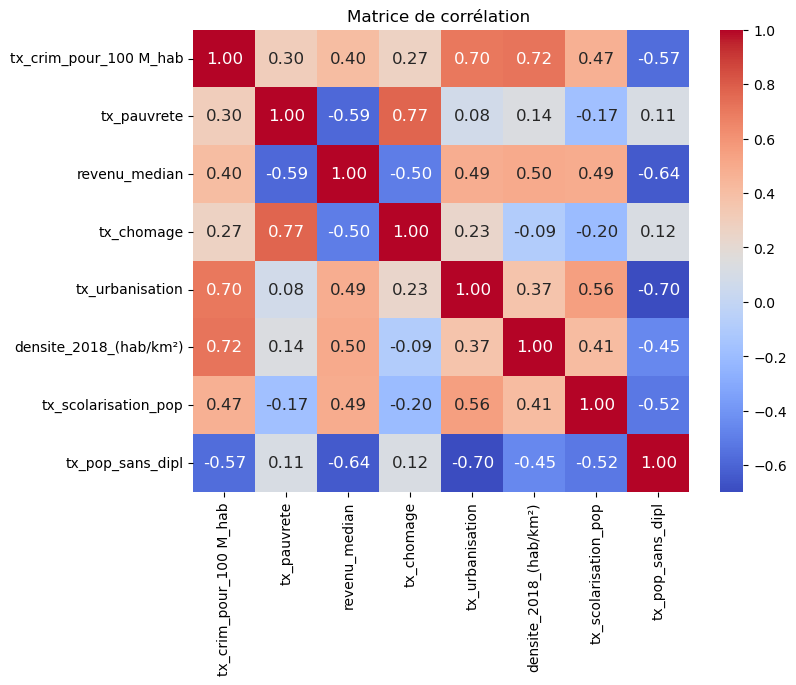

In [53]:
# Calcul de la matrice de corrélation
corr_matrix = df[['tx_crim_pour_100 M_hab','tx_pauvrete', 'revenu_median', 'tx_chomage','tx_urbanisation','densite_2018_(hab/km²)','tx_scolarisation_pop','tx_pop_sans_dipl']].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",annot_kws={"size": 12})
plt.title("Matrice de corrélation ")
plt.show()

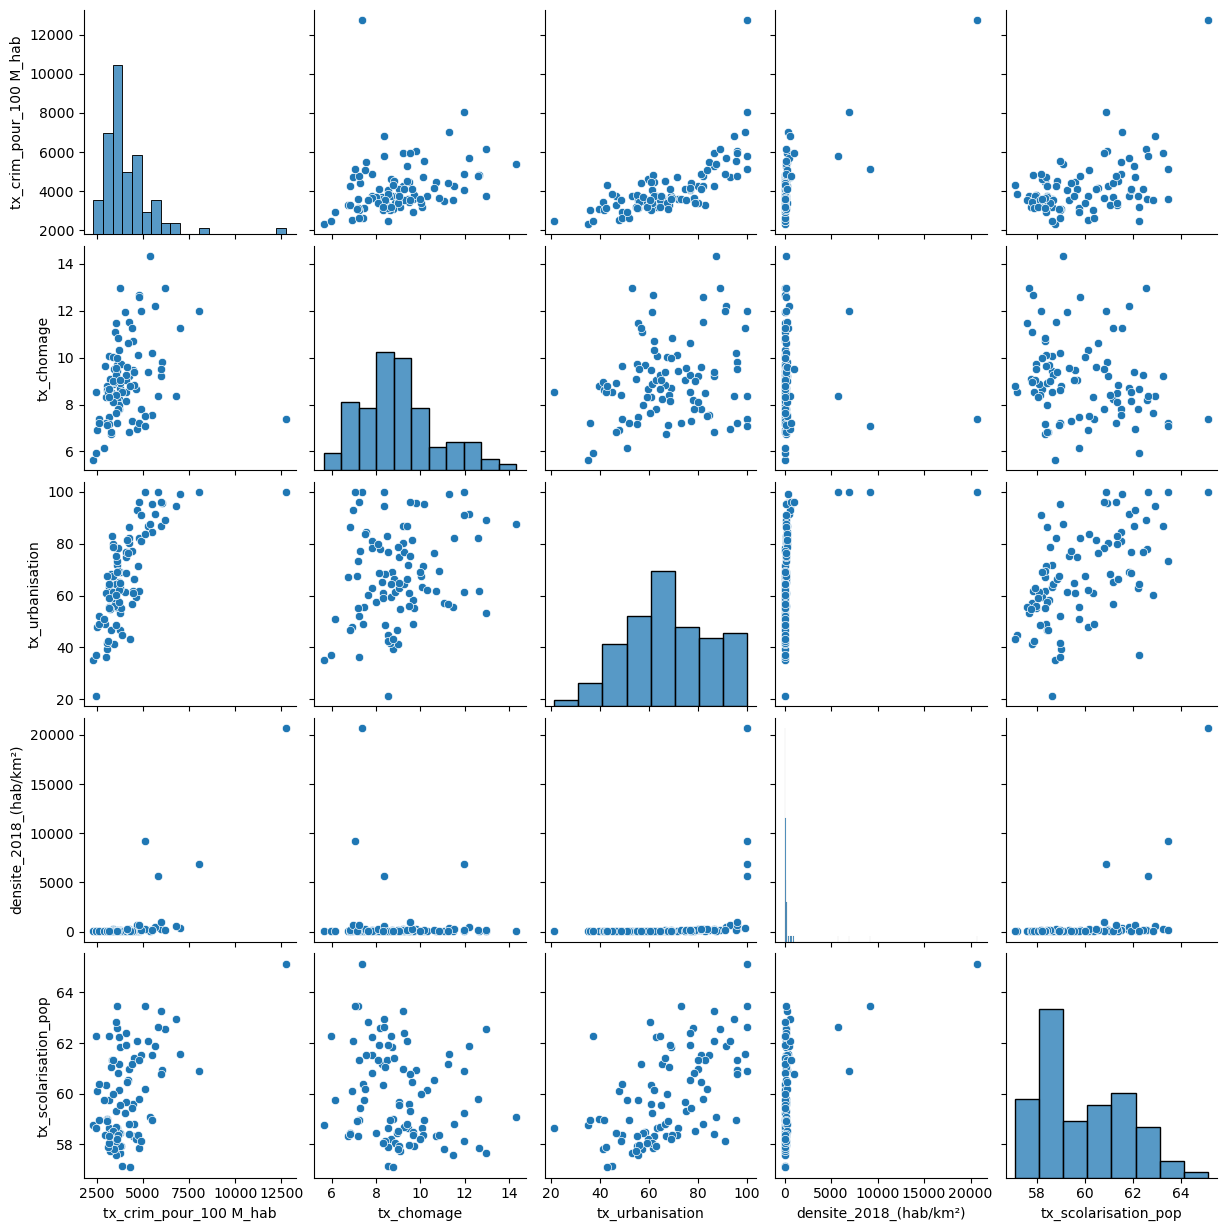

In [43]:
sns.pairplot(df[["tx_crim_pour_100 M_hab",'tx_chomage','tx_urbanisation','densite_2018_(hab/km²)','tx_scolarisation_pop']])
plt.show()


In [44]:
df.to_csv('projet_finale_vf2.csv')